In [1]:
import sys
sys.path.append('/Users/kunhao/Dropbox/code/projects/jax_late_mod/jax_cosmo_late_mod')

%pylab inline
import jax
import jax_cosmo as jc
import jax.numpy as np

print("JAX version:", jax.__version__)
#print("jax-cosmo version:", jc.__version__)
print("Using Modified Jax-cosmo from: ", jc.__file__)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
JAX version: 0.4.13
Using Modified Jax-cosmo from:  /Users/kunhao/Dropbox/code/projects/jax_late_mod/jax_cosmo_late_mod/jax_cosmo/__init__.py


In [2]:
#@title Defining some plotting functions [run me]

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

In [3]:
# Create a cosmology with default parameters
cosmo_P15 = jc.Planck15()

In [4]:
# Create one with late-time modification; keep others the same as planck15
from jax_cosmo.core import Cosmology
cosmo_modified = Cosmology(Omega_c=0.2589, Omega_b=0.04860, h=0.6774, n_s=0.9667, sigma8=0.8159, Omega_k=0.0, w0=-1.0, wa=0.0,
                           #gamma = 0.056)
                           a_late=[0.0, 0.0])

/Users/kunhao/miniconda3/envs/py38/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


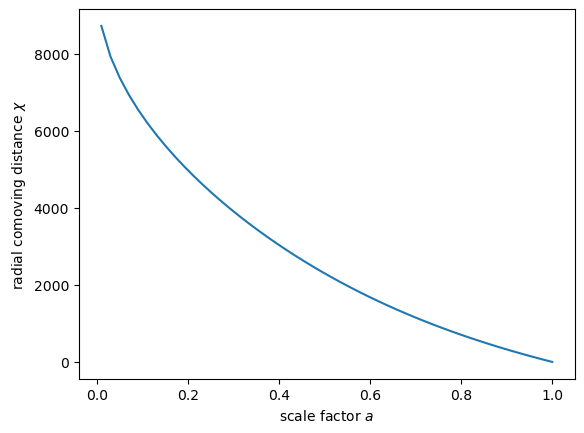

In [5]:
# Let's define a range of scale factors
a = np.linspace(0.01, 1.)

# And compute the comoving distance for these scale factors 
chi = jc.background.radial_comoving_distance(cosmo_P15, a)

# We can now plot the results:
plot(a, chi)
xlabel(r'scale factor $a$')
ylabel(r'radial comoving distance $\chi$');

In [6]:
# You can inspect the documentation to see the 
# meaning of these positional arguments
nz1 = jc.redshift.smail_nz(1., 2.,  1.)
nz2 = jc.redshift.smail_nz(1., 2.,  0.5)

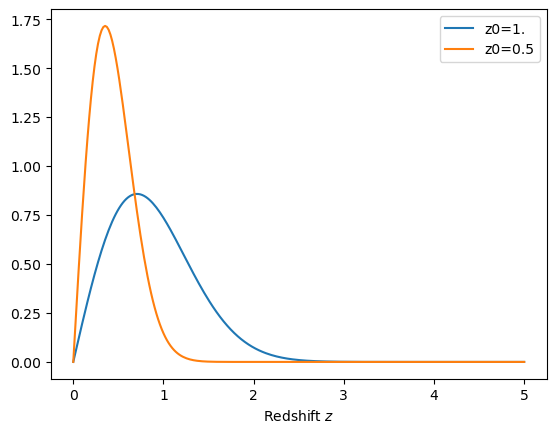

In [7]:
# And let's plot it
z = np.linspace(0,5,256)

# Redshift distributions are callable, and they return the normalized distribution
plot(z, nz1(z), label='z0=1.')
plot(z, nz2(z), label='z0=0.5')
legend();
xlabel('Redshift $z$');

In [8]:
nzs = [nz1, nz2]

probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26), 
           jc.probes.NumberCounts(nzs, jc.bias.constant_linear_bias(1.)) ]

ell = np.logspace(1,3) # Defines a range of \ell

# And compute the data vector
cls_P15 = jc.angular_cl.angular_cl(cosmo_P15, ell, probes)

In [9]:
# Cls for modified cosmology
cls_modified = jc.angular_cl.angular_cl(cosmo_modified, ell, probes)

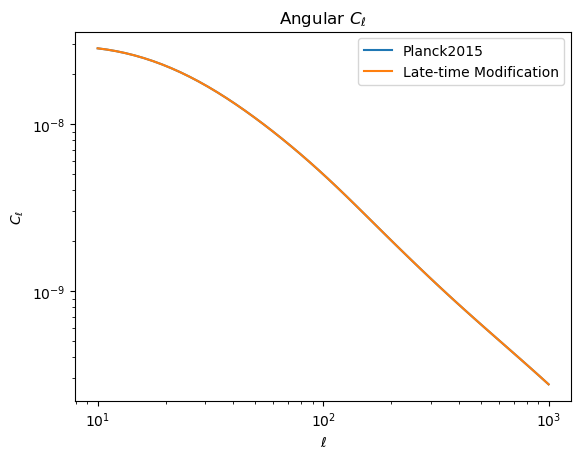

In [10]:
# This is for instance the first bin auto-spectrum 
loglog(ell, cls_P15[0],      label='Planck2015')
loglog(ell, cls_modified[0], label='Late-time Modification' )
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
title(r'Angular $C_\ell$');
plt.legend()

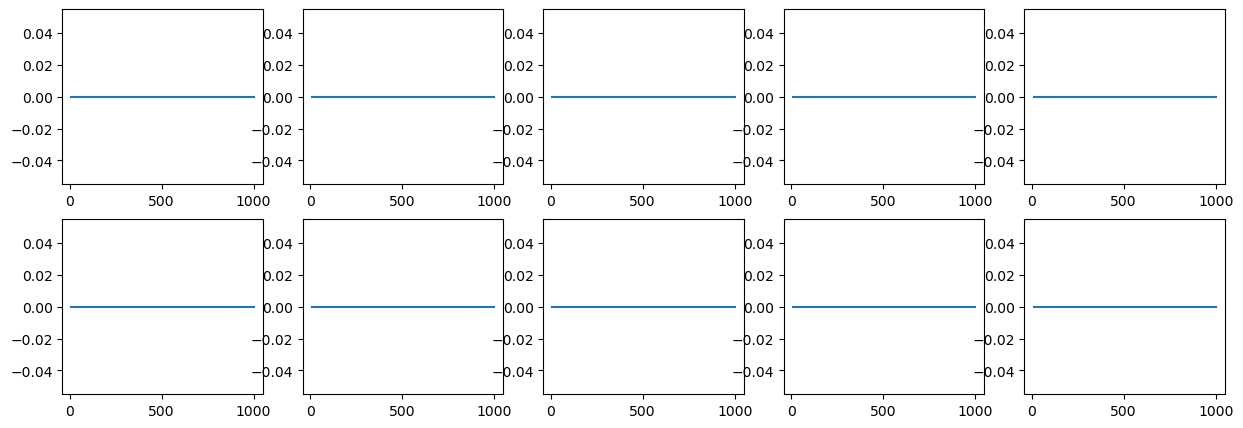

In [11]:
residue = (cls_modified - cls_P15) / cls_P15

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, residue[i*5 + j])

In [12]:
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_modified, ell, probes, sparse=True);

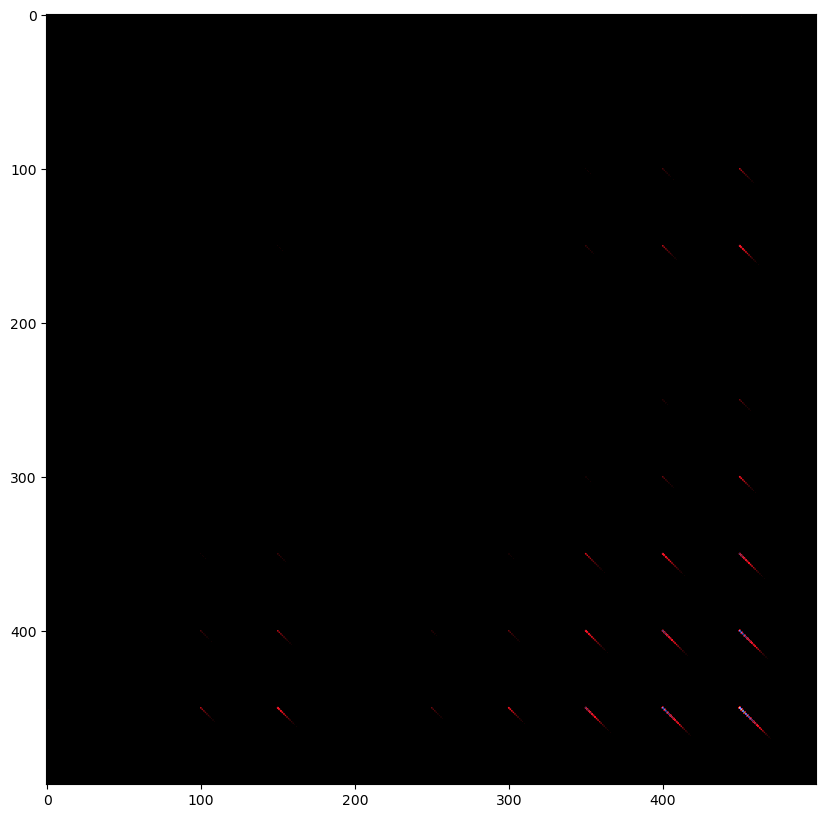

In [13]:
figure(figsize=(10,10))
# Here we convert the covariance matrix from sparse to dense reprensentation
# for plotting
imshow(np.log10(jc.sparse.to_dense(cov)+1e-11),cmap='gist_stern');

In [33]:
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_P15, ell, probes, sparse=True);

# Compile a function that computes the Hessian of the likelihood
hessian_loglik = data = mu # We create some fake data from the fiducial cosmology
# Let's define a parameter vector for Omega_cdm, sigma8, which we initialize 
# at the fiducial cosmology used to produce the data vector.

# Note the `jit` decorator for just in time compilation, this makes your code
# run fast on GPU :-)
@jax.jit
def likelihood_late(p):
  # Create a new cosmology at these parameters

  cosmo = Cosmology(Omega_c=0.2589, Omega_b=0.04860, h=0.6774, n_s=0.9667, sigma8=0.8159, Omega_k=0.0, w0=-1.0, wa=p[0],
                           #gamma = 0.056)
                           a_late=[p[1], p[1]])

  # cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])

  # Compute mean and covariance of angular Cls
  m, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, sparse=True)

  # Return likelihood value assuming constant covariance, so we stop the gradient
  # at the level of the precision matrix, and we will not include the logdet term
  # in the likelihood
  P = jc.sparse.inv(jax.lax.stop_gradient(C))
  r = data - m
  return -0.5 * r.T @ jc.sparse.sparse_dot_vec(P, r)



/Users/kunhao/miniconda3/envs/py38/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [34]:
# Compile a function that computes the Hessian of the likelihood

params_late = np.array([0.0, 0.0]) 
#params_late = np.array([cosmo_modified.Omega_c, cosmo_P15.sigma8]) 

#params_late = np.array([cosmo_modified.w0, cosmo_P15.wa]) 

hessian_loglik_late = jax.jit(jax.hessian(likelihood_late))

# Evalauate the Hessian at fiductial cosmology to retrieve Fisher matrix
# This is a bit slow at first....
F_late = - hessian_loglik_late(params_late)

In [35]:
%timeit hessian_loglik_late(params_late).block_until_ready()

597 ms ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[[   460.1483   6863.476 ]
 [  6863.478  149577.22  ]]


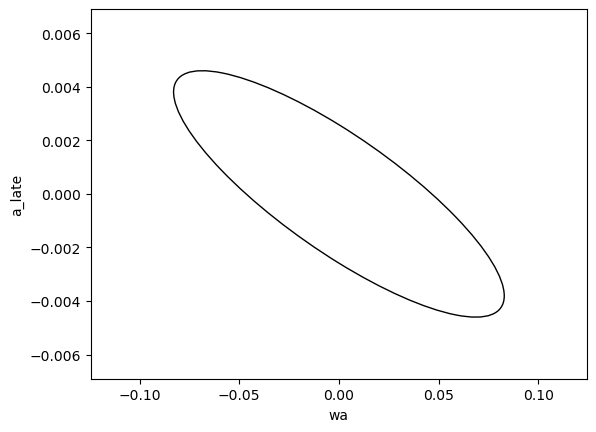

In [37]:
# We can now plot contours obtained with this
params_late = np.array([0.0, 0.0]) 

plot_contours(F_late, params_late, fill=False);
xlabel('wa')
ylabel('a_late');

print(F_late)